In [4]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size
    step_block = step % block_size
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                           block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")
    T = load_kv_tensor(fpath)

    # allow [1, seq, hidden]
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    if T.ndim != 2:
        raise ValueError(f"Expected [seq, hidden], got {tuple(T.shape)} in {fpath}")

    return T.detach().float()

def layer_similarity_for_token_range(records_dir, sample_id, token_pos, step,
                                    kind="k", layer_start=24, layer_end=31,
                                    block_size=32, block_id_base=1):
    layers = list(range(layer_start, layer_end + 1))
    vecs = []
    for layer in layers:
        T = load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                                   block_size=block_size, block_id_base=block_id_base)
        vecs.append(T[token_pos])  # [hidden]
    X = torch.stack(vecs, dim=0)                  # [L, hidden]
    Xn = F.normalize(X, dim=1, eps=1e-8)
    S = Xn @ Xn.T                                 # [L, L]
    return S, layers

def plot_layer_heatmap(S, layers, title="", savepath=None, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(6, 5), dpi=150)
    im = plt.imshow(S.numpy(), cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")
    plt.xlabel("layer")
    plt.ylabel("layer")
    plt.title(title)

    ticks = range(len(layers))
    plt.xticks(ticks, layers, rotation=45)
    plt.yticks(ticks, layers)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()




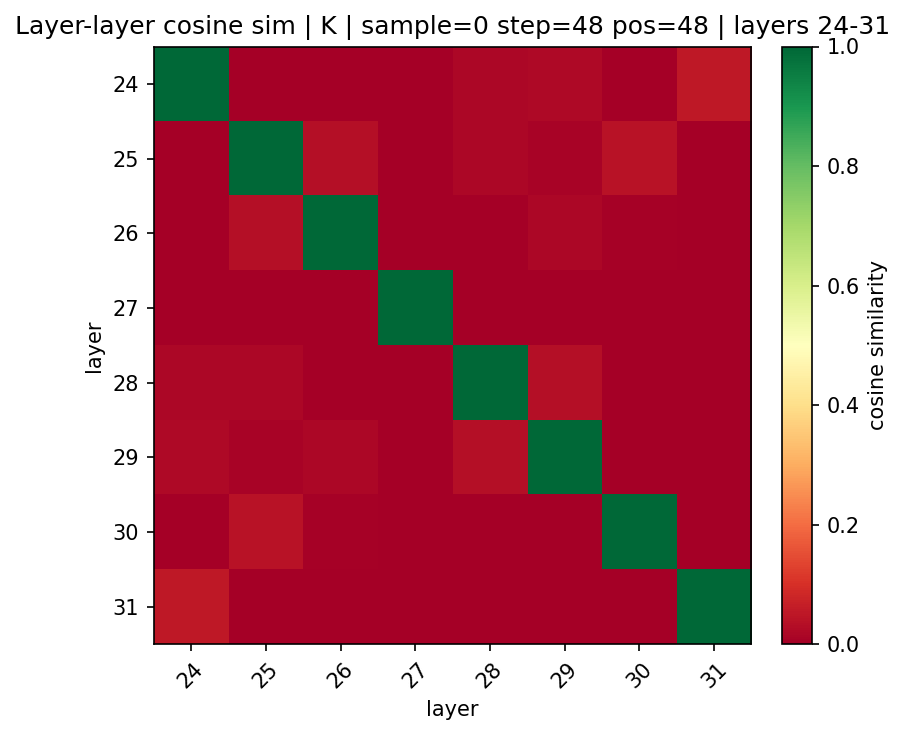

In [6]:
# ---- usage ----
records_dir = "kv_states"
sample_id = 0
token_pos = 48
step = 48
kind = "k"   # or "v"

S, layers = layer_similarity_for_token_range(
    records_dir=records_dir,
    sample_id=sample_id,
    token_pos=token_pos,
    step=step,
    kind=kind,
    layer_start=24,
    layer_end=31,
    block_id_base=0,   # matches your naming example
)

plot_layer_heatmap(
    S, layers,
    title=f"Layer-layer cosine sim | {kind.upper()} | sample={sample_id} step={step} pos={token_pos} | layers {layers[0]}-{layers[-1]}",
    savepath=f"layer_sim_{kind}_b{sample_id}_s{step}_p{token_pos}_l{layers[0]}-{layers[-1]}.png",
    vmin=0.0
)